### Performing checks for the resources available

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [2]:
!pip install transformers

     |████████████████████████████████| 1.5MB 21.7MB/s 
     |████████████████████████████████| 890kB 50.1MB/s 
     |████████████████████████████████| 2.9MB 43.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4c86f40eba3bcbbd0b283dbd65d646d51aa3bdd00929e963f52ec0a47a30c48c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Importing necessary packages

In [3]:
import pandas as pd
import numpy as np 
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [4]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Importing dataset directories

In [6]:
from os import getcwd , listdir 
from os.path import join
curr_dir = getcwd()
drive_dir = join(curr_dir , 'drive','MyDrive')
dataset_dir = join(drive_dir,'Codalab','Offensive Language Identification','Dataset')

In [7]:
listdir(dataset_dir)

['mal_full_offensive_train_corrected.csv',
 'mal_full_offensive_dev_corrected.csv',
 'kannada_offensive_dev_corrected.csv',
 'kannada_offensive_train_corrected.csv',
 'tamil_offensive_full_train_corrected.csv',
 'tamil_offensive_full_dev_corrected.csv',
 'tamil_offensive_full_test.csv',
 'mal_full_offensive_test.csv',
 'kannada_offensive_test.csv',
 '0010.png']

## Loading training data

In [8]:
train_df_path = join(dataset_dir,'kannada_offensive_train_corrected.csv')
# Load the dataset into a pandas dataframe.
train_df = pd.read_csv(train_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 6,217



,text,label
2615,Hiryaru manyaga heltidru,Not_offensive
1872,Yalla kannadigarugu ansthithu bere bashe movie...,Not_offensive
2552,Super movie guru,Not_offensive
5370,Hindi version plzzz,not-Kannada
996,ಈ ಯುಗದ ಶಂಕರ್ ನಾಗ್ ಗುರು ನೀನು all the best from...,Not_offensive
1765,It is karabu.,not-Kannada
1612,Super Junior narayana,Not_offensive
1512,Super song,Not_offensive
5806,Rj naagraj naan bigg fan...neeu prathvi aadru ...,Not_offensive
3914,Audience are customers,not-Kannada


In [9]:
train_df['label'].value_counts()

Not_offensive                           3544
not-Kannada                             1522
Offensive_Targeted_Insult_Individual     487
Offensive_Targeted_Insult_Group          329
Offensive_Untargetede                    212
Offensive_Targeted_Insult_Other          123
Name: label, dtype: int64

In [10]:

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])

In [11]:
train_df['label'].value_counts()

0    3544
5    1522
2     487
1     329
4     212
3     123
Name: label, dtype: int64

### Loading `train_sentences` and `train_labels`

In [12]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['label'].values

## Saving Class Names

In [13]:
class_names = [
               'Not_offensive','Offensive_Targeted_Insult_Group','Offensive_Targeted_Insult_Individual',
               'Offensive_Targeted_Insult_Other','Offensive_Untargetede','not-Kannada'          
]

## Loading the validation data

In [14]:
val_df_path = join(dataset_dir,'kannada_offensive_dev_corrected.csv')
# Load the dataset into a pandas dataframe.
val_df = pd.read_csv(val_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(val_df.shape[0]))

# Display 10 random rows from the data.
val_df.sample(10)

Number of training sentences: 777



,text,label
234,I like song very much,not-Kannada
776,ಕಥೆಯಲ್ಲಿ ದಮ್ ಇಲ್ಲ,Offensive_Targeted_Insult_Group
38,ಇಬ್ಬರು ಕಳ್ಳರೇ,Offensive_Targeted_Insult_Group
540,@Nandi Parthasarathi ನಿಮ್ಮ ಅವ್ವುನ್ ತುಲ್ಲಗೆ ಹಳಸ...,Offensive_Targeted_Insult_Individual
482,Yappa huchhu hidustide.....asn.....awesom,Offensive_Targeted_Insult_Other
396,ಅಭಿನಯ ಚಕ್ರವರ್ತಿ ಕಿಚ್ಚ ಸುದೀಪ್ ಅವರ ಕಡೆಯಿಂದ.. All...,Not_offensive
468,@Kiccha Vitthal ಕಚ್ಚಾ ಸುದೆಪಿ,Offensive_Targeted_Insult_Individual
675,umesh karigar Inc,not-Kannada
544,All India language madi,Not_offensive
32,Thu nem yogyathe ge maha vishnu hesaru ettu en...,Offensive_Untargetede


In [15]:
val_df['label'].value_counts()

Not_offensive                           426
not-Kannada                             191
Offensive_Targeted_Insult_Individual     66
Offensive_Targeted_Insult_Group          45
Offensive_Untargetede                    33
Offensive_Targeted_Insult_Other          16
Name: label, dtype: int64

In [16]:
val_df['label'] = le.transform(val_df['label'])

In [17]:
val_df['label'].value_counts()

0    426
5    191
2     66
1     45
4     33
3     16
Name: label, dtype: int64

### Loading `val_sentences` and `val_labels`

In [18]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['label'].values

## Handling class imbalance using `sklearn's compute_class_weight`



In [ ]:

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.85137769 0.68428184 2.74689784]


## Helper Functions

#### 1) Update Interval Function

In [19]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [20]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [21]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


### 4) Make Smart Batches (On test)

In [66]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


### 5) Function for calculating accuracy per class

In [23]:
def accuracy_per_class(preds, labels , label_dict):
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 6) Function for plotting training history

In [24]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 7) Function to check accuracy

In [25]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 8) Function to evaluate model

In [26]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)


      logits = output.logits 
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
    
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()
  
  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)
  
  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)     
    

  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 9) Function for making predictions on our test dataset

In [27]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits 

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
    
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 10) Function for making predictions on test dataset(without labels)

In [28]:
def get_predictions_on_test(py_inputs, py_attn_masks,py_ids):

    print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
    model.eval()

  # Tracking variables 
    predictions , true_labels , ids = [], [] , []

  # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
    t0 = time.time()

  # Put model in evaluation mode
    model.eval()

  # For each batch of training data...
    for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
        if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

          # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, b_input_mask)

        logits = outputs.logits 

      # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        ids.append(py_ids[step])
      # Store predictions
        predictions.append(logits)
      # Combine the results across the batches.
    predictions = np.concatenate(predictions, axis=0)
    ids = np.concatenate(ids,axis = 0)
  # Choose the label with the highest score as our prediction.
    preds = np.argmax(predictions, axis=1).flatten()

    return (ids,preds)

### 11) Confusion Matrix Helper Function

In [29]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [30]:
model_name = 'bert-base-multilingual-cased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading bert-base-multilingual-cased tokenizer...


In [31]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))       

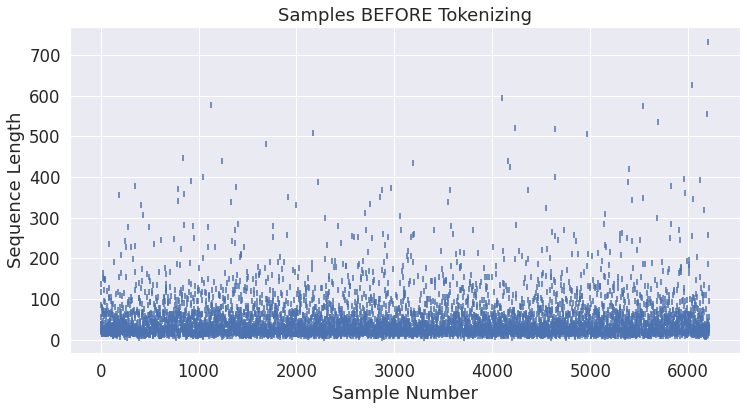

In [32]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [33]:
max_input_length = 400

In [34]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:
    
    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,           
                                 add_special_tokens=True, 
                                 max_length=max_input_length,  
                                 truncation=True,     
                                 padding=False)       
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 6,217 training samples...
  Tokenized 0 samples.
  Tokenized 600 samples.
  Tokenized 1,200 samples.
  Tokenized 1,800 samples.
  Tokenized 2,400 samples.
  Tokenized 3,000 samples.
  Tokenized 3,600 samples.
  Tokenized 4,200 samples.
  Tokenized 4,800 samples.
  Tokenized 5,400 samples.
  Tokenized 6,000 samples.
DONE.
     6,217 samples


In [35]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

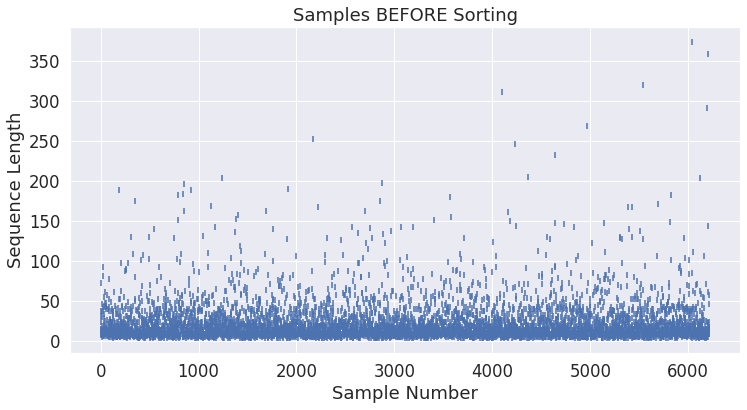

In [36]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [37]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [38]:
train_samples[0:5]

[([101, 26918, 102], 0),
 ([101, 25212, 102], 5),
 ([101, 12128, 11850, 102], 5),
 ([101, 11171, 150, 102], 5),
 ([101, 12786, 93742, 102], 5)]

In [39]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 374


In [40]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

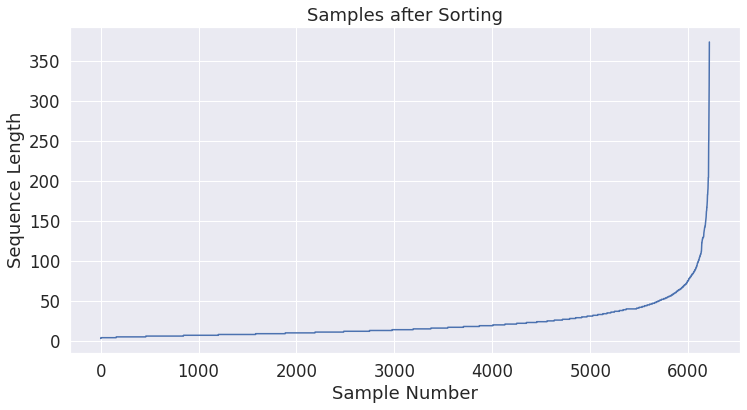

In [41]:

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [42]:
train_samples[0]

([101, 26918, 102], 0)

In [43]:
batch_size = 16

In [44]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...    
while len(train_samples) > 0:
    
    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until 
    # we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of 
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.

  DONE - 389 batches.


In [45]:
print(batch_ordered_sentences[0])

[[101, 51635, 13060, 10399, 31919, 10138, 27920, 15805, 10824, 10162, 20768, 30991, 13007, 19034, 119, 119, 182, 10731, 45466, 10129, 12011, 108, 17421, 11537, 119, 182, 11537, 11008, 11149, 11527, 11680, 50879, 14917, 13723, 100, 102], [101, 25148, 54685, 10138, 10192, 14892, 48020, 10113, 55515, 56332, 10525, 10146, 10216, 31301, 10116, 10840, 10138, 17684, 10991, 10170, 12677, 10862, 177, 26238, 10862, 13587, 10229, 10435, 10105, 12504, 14917, 10113, 70974, 74563, 10703, 102], [101, 12037, 10112, 55154, 13723, 119, 119, 119, 56237, 35659, 14441, 13410, 13986, 11680, 37403, 25388, 56237, 98042, 51930, 10347, 10853, 119, 119, 23886, 10406, 14854, 31127, 10253, 37534, 10113, 50385, 13723, 64606, 83211, 110026, 102], [101, 137, 11255, 16326, 10401, 33799, 26425, 10237, 15147, 13702, 39129, 10132, 29120, 10943, 108270, 10288, 10192, 10317, 10730, 10269, 10229, 63923, 19357, 10161, 10478, 12804, 103304, 89540, 39129, 46503, 65817, 10112, 95190, 11083, 93742, 102], [101, 1294, 25703, 14142

In [46]:
batch_ordered_labels[0]

[1, 1, 2, 3, 1, 1, 5, 2, 3, 0, 0, 1, 0, 5, 2, 2]

### Padding

In [47]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []
    
    # First, find the longest sample in the batch. 
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:
        
        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [48]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for s in batch:
    
        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 2,486,800
  Smart Batching: 147,270  (94.1% less)


## Load the model configuration from the transformers library using AutoConfig

In [49]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [50]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [51]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## Load the model from the transformers library using AutoModel

In [ ]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model 

In [ ]:

class BERT_Model(nn.Module):
    ## defining the constructor for the class
    def __init__(self, bert,num_labels):
      ## calling the super class constructor
      super(BERT_Model, self).__init__()
      ## adding the bert layer to the model
      self.bert = bert        
      # relu activation function
      self.relu =  nn.ReLU()
      # adding a dense layer to our custom model
      self.fc1 = nn.Linear(768,512)
      # adding another dense layer to our custom model ,i.e., the Output layer
      self.fc2 = nn.Linear(512,num_labels)
      # adding a softmax  activation function for our custom model's output layer
      self.softmax = nn.LogSoftmax(dim=1)

    #defining the forward pass
    def forward(self, input_id, mask):
      #pass the inputs to the model  
      outputs = self.bert(input_id,mask)
  
      last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
      pooler_output = outputs.pooler_output               ## pooler output from the model
      ## adding a fully connected layer to the BERT model
      x = self.fc1(pooler_output)
      ## applying relu activation function
      x = self.relu(x)
      # the final output layer
      x = self.fc2(x)
      # apply softmax activation to our output layer
      x = self.softmax(x)

      return x

In [ ]:


print('\nLoading model ...')
# pass the pre-trained BERT to our define architecture
model = BERT_Model(bert,num_labels=3)

model.cuda()


Loading model ...


BERT_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


## Custom Loss function

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 


## Loading Optimizer

In [52]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## Loading lr scheduler

In [53]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [54]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = {
    'epoch':[],
    'train_loss':[],
    'Training Time':[],
    'val_loss':[],
    'Validation Time':[],
    'train_acc':[],
    'val_acc':[]
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the 
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)
    
    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output.loss 
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
      
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)     
       
    training_accuracy = check_accuracy(predictions,true_labels)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(training_accuracy))
    print("  Training epoch took: {:}".format(training_time))
        
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)
    val_loss,val_accuracy,validation_time = eval_model(model,py_inputs, py_attn_masks, py_labels)  
    # Record all statistics from this epoch.

    print("")
    print("  Average validation loss: {0:.2f}".format(val_loss))
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation epoch took: {:}".format(validation_time))
    
    
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 389 batches...
  Batch      40  of      389.    Elapsed: 0:00:06.  Remaining: 0:00:52
  Batch      80  of      389.    Elapsed: 0:00:11.  Remaining: 0:00:43
  Batch     120  of      389.    Elapsed: 0:00:17.  Remaining: 0:00:38
  Batch     160  of      389.    Elapsed: 0:00:22.  Remaining: 0:00:32
  Batch     200  of      389.    Elapsed: 0:00:28.  Remaining: 0:00:27
  Batch     240  of      389.    Elapsed: 0:00:34.  Remaining: 0:00:21
  Batch     280  of      389.    Elapsed: 0:00:39.  Remaining: 0:00:15
  Batch     320  of      389.    Elapsed: 0:00:44.  Remaining: 0:00:10
  Batch     360  of      389.    Elapsed: 0:00:50.  Remaining: 0:00:04

  Average training loss: 0.97
  Training Accuracy: 0.66
  Training epoch took: 0:00:55
Creating Smart Batches from 777 examples with batch size 16...

Tokenizing 777 samples...
  Tokenized 0 samples.
  Tokenized 80 samples.
  Tokenized 160 samples.
  Tokenized 240 samples.
  Tokenized 320 samples.
  T

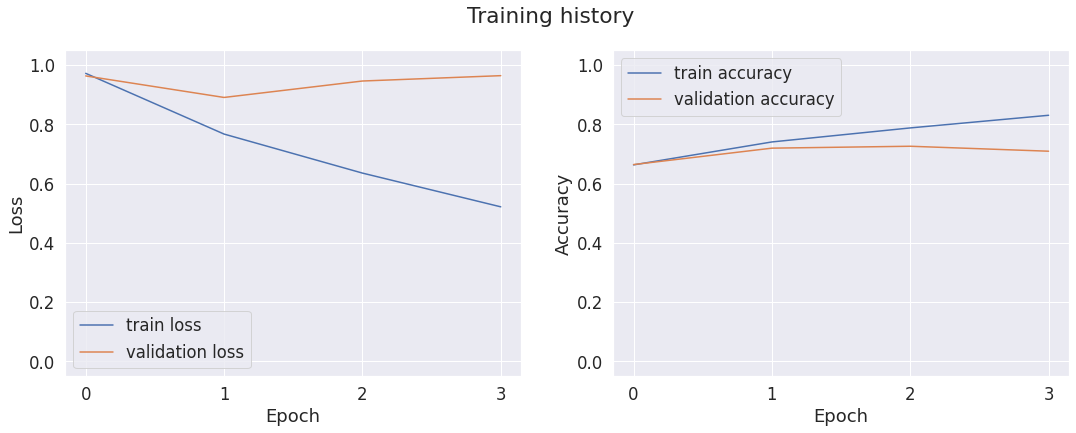

In [55]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [56]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 6,217 examples with batch size 16...

Tokenizing 6,217 samples...
  Tokenized 0 samples.
  Tokenized 600 samples.
  Tokenized 1,200 samples.
  Tokenized 1,800 samples.
  Tokenized 2,400 samples.
  Tokenized 3,000 samples.
  Tokenized 3,600 samples.
  Tokenized 4,200 samples.
  Tokenized 4,800 samples.
  Tokenized 5,400 samples.
  Tokenized 6,000 samples.
DONE.
     6,217 samples

     6,217 samples after sorting

Creating batches of size 16...

  DONE - Selected 389 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 389 test batches...
  Batch      40  of      389.    Elapsed: 0:00:01.  Remaining: 0:00:13
  Batch      80  of      389.    Elapsed: 0:00:03.  Remaining: 0:00:11
  Batch     120  of      389.    Elapsed: 0:00:04.  Remaining: 0:00:08
  Batch     160  of      389.    Elapsed: 0:00:04.  Remaining: 0:00:06
  Batch     200  of      389.    Elapsed: 0:00:05.  Remaining: 0:00:05
  Batch     240  of      389.    Elapsed: 0

In [57]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                      precision    recall  f1-score   support

                       Not_offensive       0.90      0.94      0.92      3544
     Offensive_Targeted_Insult_Group       0.55      0.61      0.58       329
Offensive_Targeted_Insult_Individual       0.82      0.88      0.85       487
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00       123
               Offensive_Untargetede       0.00      0.00      0.00       212
                         not-Kannada       0.88      0.92      0.90      1522

                            accuracy                           0.86      6217
                           macro avg       0.52      0.56      0.54      6217
                        weighted avg       0.82      0.86      0.84      6217



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


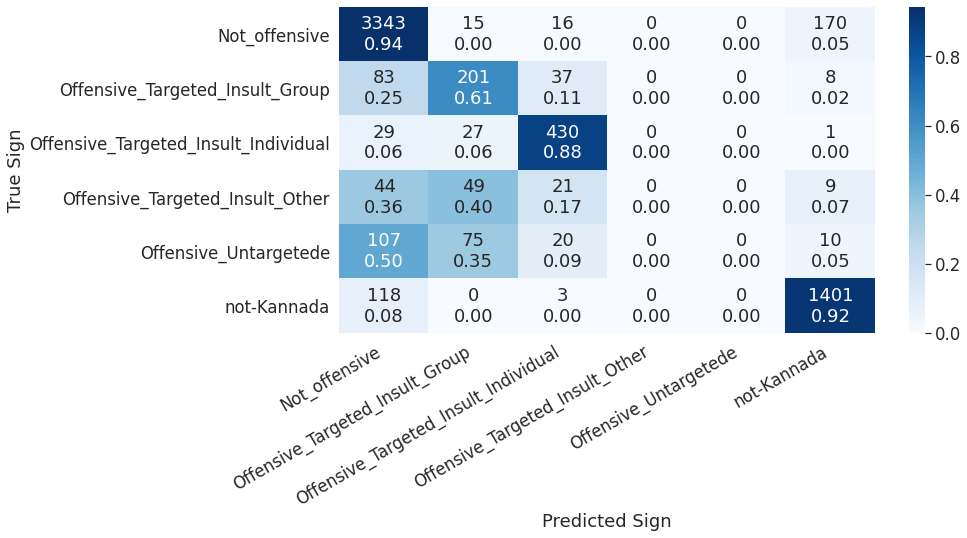

In [58]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [59]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 777 examples with batch size 16...

Tokenizing 777 samples...
  Tokenized 0 samples.
  Tokenized 80 samples.
  Tokenized 160 samples.
  Tokenized 240 samples.
  Tokenized 320 samples.
  Tokenized 400 samples.
  Tokenized 480 samples.
  Tokenized 560 samples.
  Tokenized 640 samples.
  Tokenized 720 samples.
DONE.
       777 samples

       777 samples after sorting

Creating batches of size 16...

  DONE - Selected 49 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 49 test batches...
  Batch       5  of       49.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      10  of       49.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      15  of       49.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      20  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      25  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      30  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      35  of   

In [60]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                      precision    recall  f1-score   support

                       Not_offensive       0.74      0.85      0.79       426
     Offensive_Targeted_Insult_Group       0.35      0.31      0.33        45
Offensive_Targeted_Insult_Individual       0.55      0.48      0.52        66
     Offensive_Targeted_Insult_Other       0.00      0.00      0.00        16
               Offensive_Untargetede       0.00      0.00      0.00        33
                         not-Kannada       0.76      0.75      0.76       191

                            accuracy                           0.71       777
                           macro avg       0.40      0.40      0.40       777
                        weighted avg       0.66      0.71      0.68       777



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


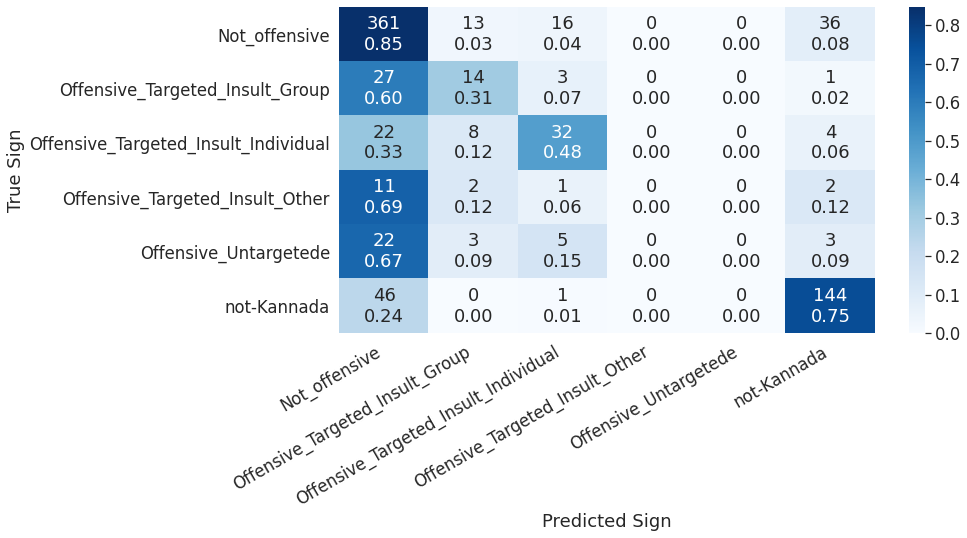

In [61]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [62]:
test_df_path = join(dataset_dir,'kannada_offensive_test.csv')
test_df = pd.read_csv(test_df_path)

In [63]:
test_df

,text
0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ
1,Anna nim e vedio nodinu mathe chaina apps use ...
2,Super anna yenu thappila yela sari agi hellidi...
3,Super sir super super super super
4,AGT-KELU (KANNADA RAP 2019)
...,...
773,Startup start maadalu capacity growth maadalu ...
774,Rashmika idanna nodi thi*a urkimbeku🤣🤣🤣🤣🤣
775,I love you sir
776,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು


## Loading `test_sentences`

In [64]:
test_sentences = test_df['text'].values 
test_ids = test_df.index.values

In [67]:
(py_inputs, py_attn_masks, py_ids) = make_smart_batches_on_test(test_sentences, test_ids, batch_size,tokenizer,max_input_length)

Creating Smart Batches from 778 examples with batch size 16...

Tokenizing 778 samples...
  Tokenized 0 samples.
  Tokenized 80 samples.
  Tokenized 160 samples.
  Tokenized 240 samples.
  Tokenized 320 samples.
  Tokenized 400 samples.
  Tokenized 480 samples.
  Tokenized 560 samples.
  Tokenized 640 samples.
  Tokenized 720 samples.
DONE.
       778 samples

       778 samples after sorting

Creating batches of size 16...

  DONE - Selected 49 batches.

Padding out sequences within each batch...
  DONE.


## Evaluating accuracy over test set

In [68]:
test_ids , test_preds = get_predictions_on_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 49 test batches...
  Batch       5  of       49.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      10  of       49.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      15  of       49.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      20  of       49.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      25  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      30  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      35  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      40  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      45  of       49.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [69]:
print(test_preds)

[5 0 5 0 0 0 0 5 0 1 0 0 0 0 0 5 0 0 1 0 2 2 0 0 0 0 0 0 2 0 0 0 5 5 0 1 0
 5 0 0 2 5 5 5 5 0 5 0 5 0 1 0 5 0 0 5 0 0 0 5 5 0 0 0 0 5 0 1 1 5 0 0 0 5
 0 0 0 2 5 0 0 5 0 5 0 2 0 0 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 2 0 0 2 0
 0 0 5 5 5 5 0 0 5 0 0 0 5 5 5 5 5 0 0 0 0 5 0 0 0 2 0 0 5 0 5 0 0 1 1 0 0
 2 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 1 0 0 0 0 0 1 0 5 5 0 5 5 0 5 5 5
 5 0 5 5 5 0 5 5 0 0 2 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 5 0 0 1 0 0 0 0 0 0
 5 5 0 2 0 0 0 0 0 2 0 0 0 0 1 0 5 0 5 5 5 5 5 0 5 5 0 5 5 0 5 0 0 0 0 5 5
 5 0 5 0 1 5 0 1 5 0 5 0 0 0 1 0 0 0 0 5 5 0 0 1 0 0 0 0 0 0 0 0 0 5 0 0 0
 0 5 0 0 0 2 0 5 5 5 5 0 0 0 0 5 0 0 5 0 5 5 0 5 0 0 5 5 0 5 5 5 5 5 5 5 5
 5 5 5 0 5 0 5 5 5 5 5 5 5 0 0 5 0 5 5 0 0 5 5 0 5 0 0 0 1 0 0 0 0 5 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0 2 0 0 2 2 5 0 0 2 0 2 2 0 0 0 0 2 5
 1 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 5 2 0 5 5 0 0 5 0 0 5 0 0 0 2 0 5 5 0 0 0
 0 5 2 0 2 0 0 0 0 0 2 1 0 0 0 5 5 2 0 5 2 0 0 0 0 0 0 2 1 0 0 2 0 0 2 0 0
 0 0 5 0 0 0 0 0 0 0 0 0 

In [70]:
le.inverse_transform(test_preds)

array(['not-Kannada', 'Not_offensive', 'not-Kannada', 'Not_offensive',
       'Not_offensive', 'Not_offensive', 'Not_offensive', 'not-Kannada',
       'Not_offensive', 'Offensive_Targeted_Insult_Group',
       'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive',
       'Not_offensive', 'not-Kannada', 'Not_offensive', 'Not_offensive',
       'Offensive_Targeted_Insult_Group', 'Not_offensive',
       'Offensive_Targeted_Insult_Individual',
       'Offensive_Targeted_Insult_Individual', 'Not_offensive',
       'Not_offensive', 'Not_offensive', 'Not_offensive', 'Not_offensive',
       'Not_offensive', 'Offensive_Targeted_Insult_Individual',
       'Not_offensive', 'Not_offensive', 'Not_offensive', 'not-Kannada',
       'not-Kannada', 'Not_offensive', 'Offensive_Targeted_Insult_Group',
       'Not_offensive', 'not-Kannada', 'Not_offensive', 'Not_offensive',
       'Offensive_Targeted_Insult_Individual', 'not-Kannada',
       'not-Kannada', 'not-Kannada', 'not-Kannada', 'Not_o

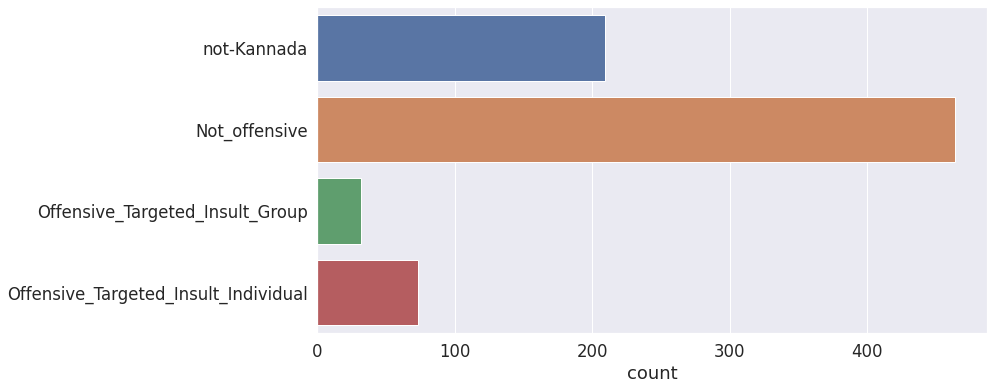

In [71]:
sns.countplot(y =le.inverse_transform(test_preds))

## Saving the model

In [72]:
torch.save(model,"./drive/MyDrive/Codalab/Offensive Language Identification/Models/BERTForSequenceClassification_Multilingual_Kannada_v2")

## Creating Submission DataFrame

In [75]:
df_new = pd.DataFrame({
    'id':test_ids,
    'label':le.inverse_transform(test_preds)
})

In [76]:
test_df['id'] = test_df.index

In [77]:
df_new

,id,label
0,520,not-Kannada
1,540,Not_offensive
2,574,not-Kannada
3,587,Not_offensive
4,592,Not_offensive
...,...,...
773,16,not-Kannada
774,393,Not_offensive
775,397,Not_offensive
776,569,Not_offensive


In [78]:
test_df

,text,id
0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,0
1,Anna nim e vedio nodinu mathe chaina apps use ...,1
2,Super anna yenu thappila yela sari agi hellidi...,2
3,Super sir super super super super,3
4,AGT-KELU (KANNADA RAP 2019),4
...,...,...
773,Startup start maadalu capacity growth maadalu ...,773
774,Rashmika idanna nodi thi*a urkimbeku🤣🤣🤣🤣🤣,774
775,I love you sir,775
776,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು,776


In [79]:
df_f = pd.merge(test_df,df_new,on = 'id')
df_f

,text,id,label
0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,0,Not_offensive
1,Anna nim e vedio nodinu mathe chaina apps use ...,1,Not_offensive
2,Super anna yenu thappila yela sari agi hellidi...,2,Not_offensive
3,Super sir super super super super,3,not-Kannada
4,AGT-KELU (KANNADA RAP 2019),4,not-Kannada
...,...,...,...
773,Startup start maadalu capacity growth maadalu ...,773,Not_offensive
774,Rashmika idanna nodi thi*a urkimbeku🤣🤣🤣🤣🤣,774,Not_offensive
775,I love you sir,775,not-Kannada
776,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು,776,Not_offensive


In [80]:
df_f = df_f[['id','text','label']]
df_f

,id,text,label
0,0,ಜೈ ಮೋರಿ ಜೈ ರೋಗಿ ಇಸ್ಲಾಂ ಸಾಯಿಸಿ ಇದೆ ಇವರ ಗುರಿ,Not_offensive
1,1,Anna nim e vedio nodinu mathe chaina apps use ...,Not_offensive
2,2,Super anna yenu thappila yela sari agi hellidi...,Not_offensive
3,3,Super sir super super super super,not-Kannada
4,4,AGT-KELU (KANNADA RAP 2019),not-Kannada
...,...,...,...
773,773,Startup start maadalu capacity growth maadalu ...,Not_offensive
774,774,Rashmika idanna nodi thi*a urkimbeku🤣🤣🤣🤣🤣,Not_offensive
775,775,I love you sir,not-Kannada
776,776,ನೋಡ್ತಾ ಹೋದ್ರೆ ಸಾವಿರಾರು lyrical video ಗಳು,Not_offensive


## Saving Submission DataFrame

In [81]:
path = './drive/MyDrive/Codalab/Offensive Language Identification/SubmissionFiles'

In [82]:
df_f.to_csv(join(path,'bert_multi_kannada.csv'),index=False)